### Imports

In [37]:
import scipy as sci
from scipy import stats
from scipy.special import expit
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib widget


### Read Data

In [11]:
file = 'examen.csv'
data = pd.read_csv(file, index_col=None, header=None).reset_index(drop=True)
N_S = len(data.index)
indices = data.index

### Preprocess

In [12]:
def set_axis_labels(ax, x, y, z=None):
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    if z != None:
        ax.set_zlabel(z)
    
X_S = data.iloc[:, :3]

def normalize(points):
    min = points.min(axis=0)
    scale = points.max(axis=0) - min
    def denormalize(points):
        return points * scale + min
    return (points - min) / scale, denormalize

X_S, denormalize = normalize(X_S)
X_S, Y_S = X_S.iloc[:, :2], X_S.iloc[:, 2]

def label_to_int(data):
    labels = data.unique()
    label_map = dict(zip(labels, range(len(labels))))
    return data.apply(lambda x: label_map[x]), labels

#Y_S, labels = label_to_int(Y_S)

### Learner measures

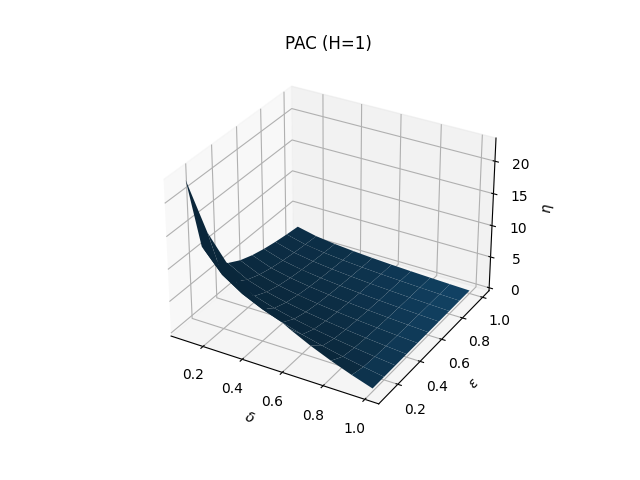

In [13]:
# lower bound to sample size
def PAC_eta(H_norm, delta, epsilon):
    return (np.log(H_norm) - np.log(delta))/epsilon

# lower bound to generalization error
def PAC_delta(H_norm, epsilon, eta):
    return H_norm/np.exp(eta*epsilon)

H = 1
plt.figure()
X = Y = np.linspace(0.1, 1, 10)
X, Y = np.meshgrid(X, Y)
ax = plt.axes(projection='3d', title=f'PAC (H={H})')
ax.plot_surface(X, Y, PAC_eta(H, X, Y))
set_axis_labels(ax, '$\\delta$', '$\\varepsilon$', '$\\eta$')
#print(X,Y)


# Sampling

##### Distributions

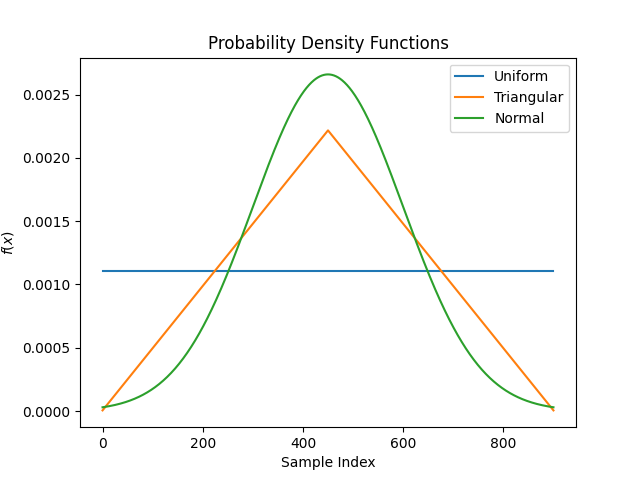

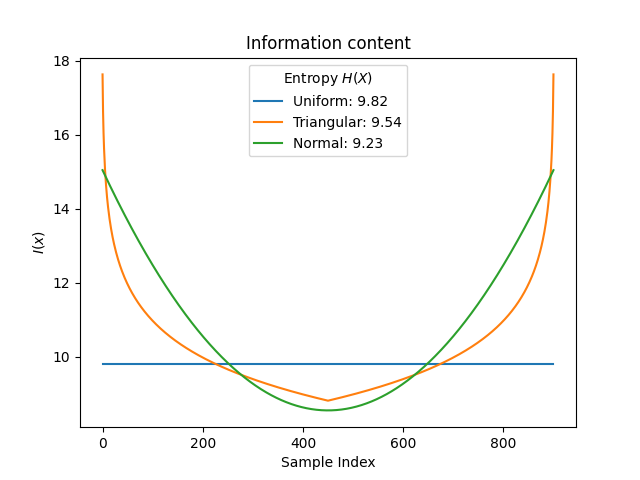

In [14]:
pdf_names = ["Uniform", "Triangular", "Normal"]


def pdf(pdf, x, N):
    return pd.Series(dict(zip(pdf_names, [
        sci.stats.uniform.pdf(x, 0, N),
        sci.stats.triang.pdf(x, 0.5, -1, N+1),
        sci.stats.norm.pdf(x, N//2, N//6)])
        )[pdf], index=x)


plt.figure()
ax = plt.axes(title="Probability Density Functions")
for name in pdf_names:
    F = pdf(name, indices, N_S)
    ax.plot(indices, F, label=name)
plt.legend()
set_axis_labels(ax, "Sample Index", "$f(x)$")

plt.figure()
ax = plt.axes(title="Information content")
for name in pdf_names:
    F = pdf(name, indices, N_S)
    I = np.log2(1/F)
    H = np.sum(-F*np.log2(F))
    plt.plot(indices, I, label=f"{name}: {H:.2f}")
plt.legend(title="Entropy $H(X)$")
set_axis_labels(ax, "Sample Index", "$I(x)$")


##### Comparison of samples

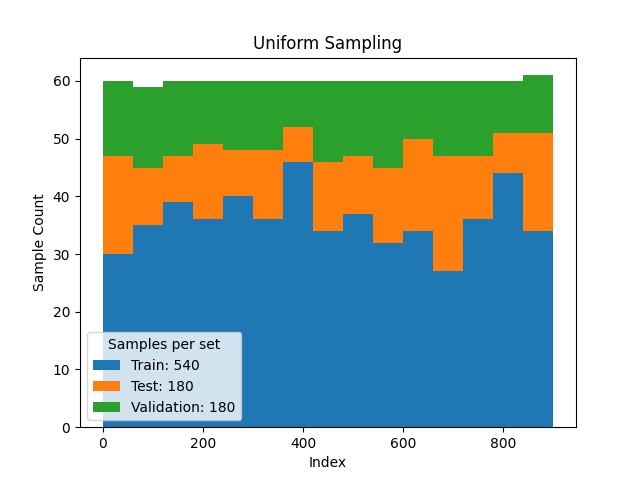

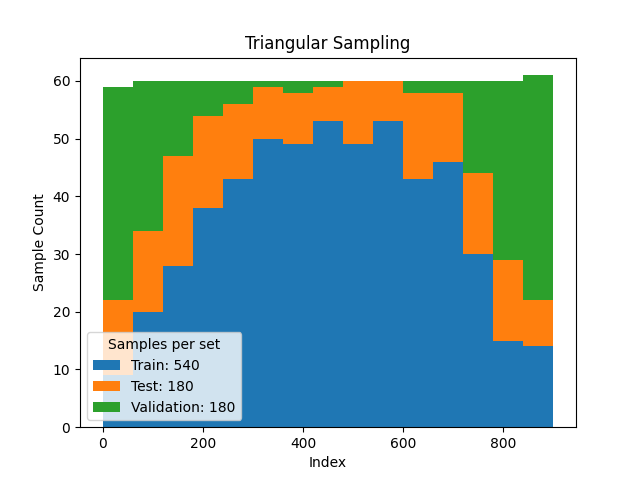

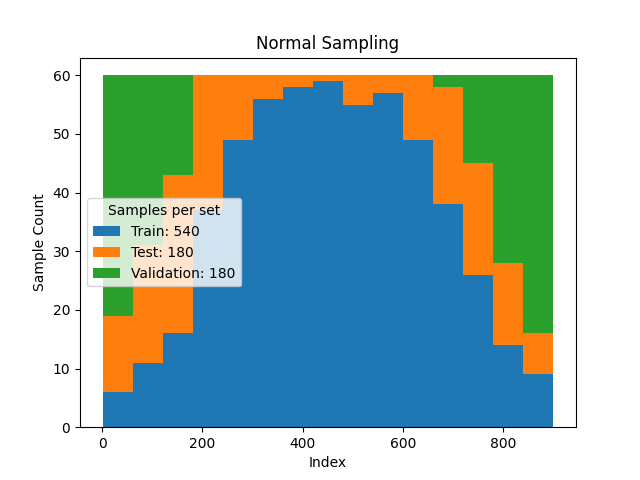

In [15]:
sets = {"Train": int(0.6*N_S),
        "Test": int(0.2*N_S),
        "Validation": int(0.2*N_S)}

sets_uniform = sets.copy()

for name in pdf_names:
    weights = pdf(name, indices, N_S)
    sets_curr = sets.copy()
    plt.figure()
    ax = plt.axes(title=f"{name} Sampling")
    
    for k, v in sets_curr.items():
        X_sample = X_S.iloc[weights.index, :2].sample(n=v, weights=weights)
        if name == "Uniform":
            sets_uniform[k] = (X_sample, Y_S.iloc[X_sample.index])
        weights = weights.drop(X_sample.index)
        sets_curr[k] = X_sample.index

    ax.hist(sets_curr.values(), stacked=True, bins=15,
        label=[f"{k}: {len(v)}" for k, v in sets_curr.items()]) 
    set_axis_labels(ax, 'Index', 'Sample Count')   
    plt.legend(title="Samples per set")

# Supervised Learning

### Neural Network

##### Definition

In [16]:
def to_vector(Y, cats):
    id = np.identity(cats)
    return np.array([id[c, :] for c in Y])
    
def update(X, Yd, W, B, phi, dphi):
    p = X.shape[1]

    # feedforward
    V = [None] * (k+1)
    Y = [None] * (k+1)
    Y[0] = X
    for l in range(1, k+1):
        V[l] = W[l] @ Y[l-1]
        if B != None:
            V[l] += B[l]
        Y[l] = phi(V[l])
    #softmax = lambda x: np.exp(x) / sum(np.exp(x))
    #dsoftmax = lambda x: np.diag(softmax(x).flatten()) @ (np.eye(x.shape[0]) - softmax(x))

    # backpropagation
    dE = Y[k] - Yd
    E = ((Y[k] - Yd)**2)/2

    delta = [None] * (k+1)
    delta[k] = dE * dphi(V[k])
    for l in reversed(range(1, k)):
        delta[l] = (W[l+1].T @ delta[l+1]) * dphi(V[l])

    # update
    for l in range(1, k+1):
        W[l] -= (delta[l] @ Y[l-1].T) / p
        if B != None:
            B[l] -= (delta[l] @ np.ones((p, 1))) / p
    return W, B, delta, E


##### Run

In [44]:
X, Yd = sets_uniform["Train"]
X, Yd = X.to_numpy().T, Yd.to_numpy()[:, None].T
X_test, Y_test = sets_uniform["Test"]
X_test, Y_test = X_test.to_numpy().T, Y_test.to_numpy().T

neurons = [X.shape[0], 2, 2, Yd.shape[0]]
k = len(neurons) - 1
epochs = 1000

np.random.seed(69)
W = [None] * (k+1)
B = [None] * (k+1)
for l in range(1, k+1):
    W[l] = np.random.randn(neurons[l], neurons[l-1])
    B[l] = np.random.randn(neurons[l])[:, None]
phi = expit
def dphi(x): return phi(x) * (1 - phi(x))

deltas = []
errors = {"Train": [],
          "Test": [],
          "Validation": []}
ys = []
for i in range(epochs):
    W, B, delta, E = update(X, Yd, W, B, phi, dphi)
    deltas.append([np.mean(np.sum(np.abs(delta[l]), axis=0))
        for l in range(1, k+1)])
    errors["Train"].append(np.sum(E, axis=1)/X.shape[1])
    Y_last = X_test
    for l in range(1, k+1):
        V_last = W[l] @ Y_last + B[l]
        Y_last = phi(V_last)
    E = ((Y_last - Y_test)**2)/2
    errors["Test"].append(np.sum(E, axis=1)/Y_last.shape[1])
    ys.append([Y_last])

deltas = np.array(deltas).T

##### Graphs

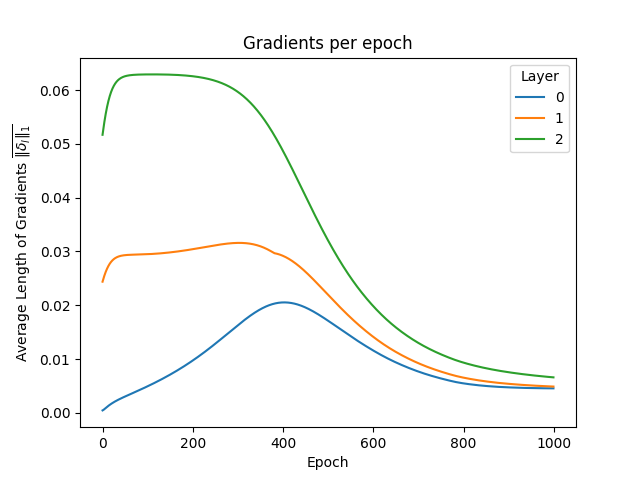

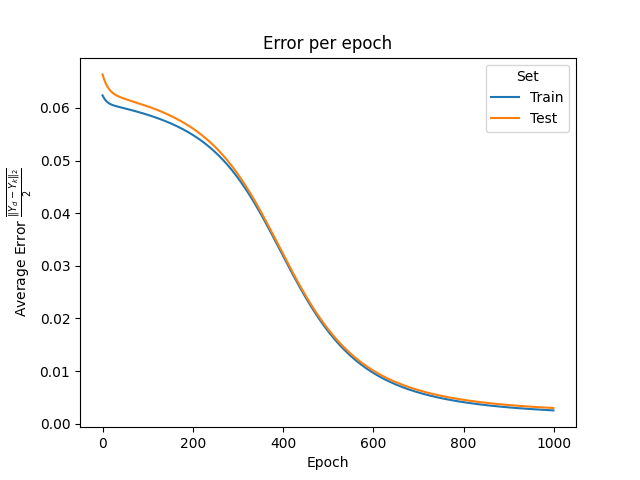

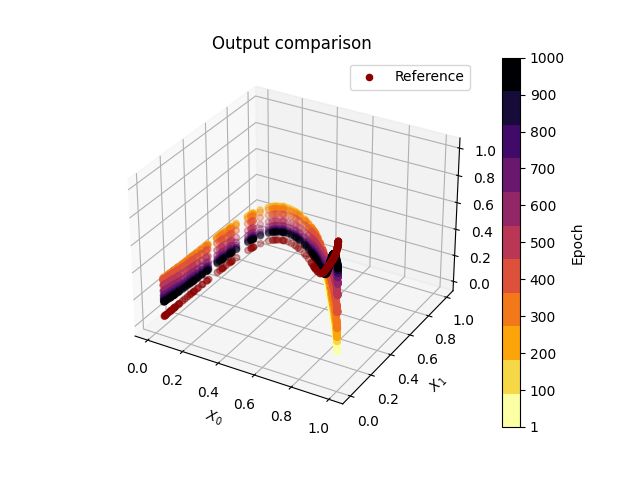

In [18]:
from turtle import position


plt.figure()
ax = plt.axes(title=f"Gradients per epoch")
ax.plot(range(epochs), deltas.T, label=range(deltas.shape[0]))
ax.legend(title="Layer")
set_axis_labels(ax, "Epoch", 
    "Average Length of Gradients $\\overline{\\Vert\\delta_l\\Vert_1}$")

plt.figure()
ax = plt.axes(title=f"Error per epoch")
ax.plot(range(epochs), errors["Train"], label="Train")
ax.plot(range(epochs), errors["Test"], label="Test")
plt.legend(title="Set")
set_axis_labels(ax, "Epoch",
    "Average Error $\\frac{\\overline{\\Vert Y_d - Y_k\\Vert_2}}{2}$")

plt.figure()
plot_N = 11
cmap = plt.get_cmap("inferno_r", plot_N)
ticks = np.linspace(0, len(ys)-1, plot_N, dtype=int)
ax = plt.axes(projection="3d", title=f"Output comparison")
ax.scatter(X_test[0, :], X_test[1, :], Y_test, label="Reference", color = 'darkred')
for c, k in enumerate(ticks):
    ax.scatter(X_test[0, :], X_test[1, :], ys[k][0], color = cmap(c))

plt.legend()
norm = mpl.colors.Normalize(vmin=0, vmax=len(ys))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ticks=ticks+1, ax=ax)
cbar.ax.set_yticklabels(ticks+1)
cbar.set_label("Epoch")
set_axis_labels(ax, "$X_0$", "$X_1$", "$Y_0$")


# Unsupervised Learning

### Norms

In [72]:
norm_names = [
    "Euclidean2",
    "Manhattan",
    "Infinity",
    "Mahalanobis2"
]

norm = dict(zip(norm_names, [
    lambda x: np.sum(x**2, axis=0,),
    lambda x: np.sum(np.abs(x), axis=0),
    lambda x: np.max(np.abs(x), axis=0),
    lambda S: lambda x: np.squeeze(np.concatenate(
        [c[None, :] @ inv(S) @ c[:, None] for c in x.T]))
]))


### K-means

In [104]:
def cost_intracluster(X, C, norm):
    return np.sum(norm(X-C))


temp = X[:, 0:10]
tempC = [(X[:, [0]], []), (X[:, [0]], [])]
tempC[0][1].extend([n for n in range(0, 10, 2)])
tempC[1][1].extend([n for n in range(1, 10, 2)])

def cost(X, C, norm):
    acum = 0
    for c in range(len(C)):
        acum += cost_intracluster(X[:, C[c][1]], C[c][0], norm)
    return acum

print(cost(temp, tempC, norm["Euclidean2"]))

1.6963881826517373
